<a href="https://colab.research.google.com/github/JacksonSprigg/DevInterp-MATS-Application/blob/main/RLCT_noise_post_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RLCT response to input noise across MLPs, CNNs and AEs.**

## Installs, imports and mount

In [78]:
from google.colab import drive
drive.mount('/content/drive')

model_save_dir = '/content/drive/MyDrive/DevInterp/Noise/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%pip install devinterp matplotlib seaborn torchvision -q

In [95]:
import os
import csv
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT
from devinterp.slt import estimate_learning_coeff, plot_learning_coeff_trace, estimate_learning_coeff_with_summary

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Initialise models

### All ~2 million params

### MLP

In [6]:
def train_one_epoch_mlp(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate_mlp(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)

class Net(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

### CNN

In [7]:
def train_one_epoch_cnn(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate_cnn(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
    return test_loss / len(test_loader)

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(40 * 7 * 7, 800)
        self.fc2 = nn.Linear(800, 400)
        self.fc3 = nn.Linear(400, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 40 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### AutoEncoder

In [8]:
def train_one_epoch_ae(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for data, _ in tqdm(train_loader):
        data = data.view(data.size(0), -1).to(device)
        optimizer.zero_grad()
        reconstructed = model(data)
        loss = criterion(reconstructed, data)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate_ae(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(data.size(0), -1).to(device)
            reconstructed = model(data)
            loss = criterion(reconstructed, data)
            test_loss += loss.item()
    return test_loss / len(test_loader)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=784, out_features=800)
        self.enc2 = nn.Linear(in_features=800, out_features=300)
        self.enc3 = nn.Linear(in_features=300, out_features=250)

        self.dec1 = nn.Linear(in_features=250, out_features=300)
        self.dec2 = nn.Linear(in_features=300, out_features=800)
        self.dec3 = nn.Linear(in_features=800, out_features=784)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        return x

## Data loaders

In [12]:
batch_size = 512

# Noise adding function
def add_noise(noise_level):
    def add_noise_inner(img):
        noise = torch.randn(img.size()) * noise_level
        noisy_img = img + noise
        return noisy_img.clamp(0, 1)
    return add_noise_inner

# Define transforms for different noise levels
transform_noisy_01 = transforms.Compose([
    transforms.ToTensor(),
    add_noise(0.1)
])

transform_noisy_02 = transforms.Compose([
    transforms.ToTensor(),
    add_noise(0.2)
])

transform_noisy_03 = transforms.Compose([
    transforms.ToTensor(),
    add_noise(0.3)
])

# Load MNIST data with different levels of noise
train_data_noisy_01 = datasets.MNIST("../data", train=True, download=True, transform=transform_noisy_01)
train_loader_noisy_01 = DataLoader(train_data_noisy_01, batch_size=batch_size, shuffle=True)

train_data_noisy_02 = datasets.MNIST("../data", train=True, download=True, transform=transform_noisy_02)
train_loader_noisy_02 = DataLoader(train_data_noisy_02, batch_size=batch_size, shuffle=True)

train_data_noisy_03 = datasets.MNIST("../data", train=True, download=True, transform=transform_noisy_03)
train_loader_noisy_03 = DataLoader(train_data_noisy_03, batch_size=batch_size, shuffle=True)

# Load regular train data
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


## Train Models

In [66]:
n_epochs = 25 # Max epochs

lr = 0.005
loss_threshold_mlp = 0.2
loss_threshold_cnn = 0.05
loss_threshold_ae  = 0.09

In [80]:
# Function to save models

def save_models(models, model_name_prefix):
    for epoch, model in enumerate(models):
        model_filename = f'{model_save_dir}{model_name_prefix}_epoch_{epoch+1}.pt'
        torch.save(model.state_dict(), model_filename)

def save_arrays_to_drive(*array_info):
    # Ensure the directory exists
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    # Iterate over each array and its name
    for name, array in array_info:
        file_path = os.path.join(model_save_dir, f'{name}.csv')

        # Save the array to a CSV file
        np.savetxt(file_path, array, delimiter=',')

### MLP1 - Normal train data

In [15]:
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader
test_loader_using = test_loader

train_losses_mlp1 = []
test_losses_mlp1 = []
models_mlp1 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_mlp(model, train_loader_using, optimizer, criterion)
    test_loss = evaluate_mlp(model, test_loader_using, criterion)

    train_losses_mlp1.append(train_loss)
    test_losses_mlp1.append(test_loss)
    models_mlp1 += [copy.deepcopy(model)]

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")

    # Check if test_loss is below the threshold
    if test_loss < loss_threshold_mlp:
        print(f"Stopping early as loss dropped below {loss_threshold_mlp}")
        break

100%|██████████| 118/118 [00:10<00:00, 11.48it/s]


Epoch 1, Train Loss: 1.9818972328961906, Test Loss: 1.267601639032364


100%|██████████| 118/118 [00:07<00:00, 14.77it/s]


Epoch 2, Train Loss: 0.7705047979193219, Test Loss: 0.5142301380634308


100%|██████████| 118/118 [00:07<00:00, 16.07it/s]


Epoch 3, Train Loss: 0.4577839013378499, Test Loss: 0.3947748601436615


100%|██████████| 118/118 [00:08<00:00, 14.52it/s]


Epoch 4, Train Loss: 0.3802068405232187, Test Loss: 0.34720767587423323


100%|██████████| 118/118 [00:07<00:00, 15.87it/s]


Epoch 5, Train Loss: 0.3416067846750809, Test Loss: 0.3174866668879986


100%|██████████| 118/118 [00:08<00:00, 14.39it/s]


Epoch 6, Train Loss: 0.3168666838841923, Test Loss: 0.298067457228899


100%|██████████| 118/118 [00:08<00:00, 14.55it/s]


Epoch 7, Train Loss: 0.29749490295426323, Test Loss: 0.2846526257693768


100%|██████████| 118/118 [00:07<00:00, 14.80it/s]


Epoch 8, Train Loss: 0.28251516920025066, Test Loss: 0.2707431688904762


100%|██████████| 118/118 [00:07<00:00, 15.20it/s]


Epoch 9, Train Loss: 0.26829197762881296, Test Loss: 0.25755873024463655


100%|██████████| 118/118 [00:08<00:00, 14.39it/s]


Epoch 10, Train Loss: 0.2557304500270698, Test Loss: 0.24697678163647652


100%|██████████| 118/118 [00:08<00:00, 14.61it/s]


Epoch 11, Train Loss: 0.2438847065224486, Test Loss: 0.2388149756938219


100%|██████████| 118/118 [00:07<00:00, 15.66it/s]


Epoch 12, Train Loss: 0.23406686444403763, Test Loss: 0.2294044502079487


100%|██████████| 118/118 [00:08<00:00, 14.67it/s]


Epoch 13, Train Loss: 0.22376174290301437, Test Loss: 0.21824579127132893


100%|██████████| 118/118 [00:07<00:00, 15.28it/s]


Epoch 14, Train Loss: 0.21484205379324445, Test Loss: 0.21100128144025804


100%|██████████| 118/118 [00:08<00:00, 14.59it/s]


Epoch 15, Train Loss: 0.20547395439471228, Test Loss: 0.2024863876402378


100%|██████████| 118/118 [00:07<00:00, 15.80it/s]


Epoch 16, Train Loss: 0.19789364567752613, Test Loss: 0.1958246111869812
Stopping early as loss dropped below 0.2


In [81]:
save_models(models_mlp1, 'mlp1')
save_arrays_to_drive(
    ('train_losses_mlp1', train_losses_mlp1),
    ('test_losses_mlp1', test_losses_mlp1),
)

### MLP2 - 0.1 Noise

In [19]:
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader_noisy_01
test_loader_using = test_loader

train_losses_mlp2 = []
test_losses_mlp2 = []
models_mlp2 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_mlp(model, train_loader_using, optimizer, criterion)
    test_loss = evaluate_mlp(model, test_loader_using, criterion)
    train_losses_mlp2.append(train_loss)
    test_losses_mlp2.append(test_loss)
    models_mlp2 += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")

     # Check if test_loss is below the threshold
    if test_loss < loss_threshold_mlp:
        print(f"Stopping early as loss dropped below {loss_threshold_mlp}")
        break

100%|██████████| 118/118 [00:13<00:00,  8.79it/s]


Epoch 1, Train Loss: 2.0183119864787087, Test Loss: 1.3395852327346802


100%|██████████| 118/118 [00:13<00:00,  8.73it/s]


Epoch 2, Train Loss: 0.8390280265929335, Test Loss: 0.5390901640057564


100%|██████████| 118/118 [00:12<00:00,  9.68it/s]


Epoch 3, Train Loss: 0.48315340659375916, Test Loss: 0.4062335379421711


100%|██████████| 118/118 [00:12<00:00,  9.32it/s]


Epoch 4, Train Loss: 0.39703334261805323, Test Loss: 0.3560499384999275


100%|██████████| 118/118 [00:13<00:00,  8.95it/s]


Epoch 5, Train Loss: 0.35752484934814904, Test Loss: 0.33114644810557364


100%|██████████| 118/118 [00:13<00:00,  8.79it/s]


Epoch 6, Train Loss: 0.33460508312209175, Test Loss: 0.3133023515343666


100%|██████████| 118/118 [00:11<00:00, 10.42it/s]


Epoch 7, Train Loss: 0.31573278040198954, Test Loss: 0.30042374357581136


100%|██████████| 118/118 [00:11<00:00,  9.85it/s]


Epoch 8, Train Loss: 0.3028285508438692, Test Loss: 0.2879914648830891


100%|██████████| 118/118 [00:13<00:00,  8.80it/s]


Epoch 9, Train Loss: 0.29024660713591816, Test Loss: 0.27840509042143824


100%|██████████| 118/118 [00:13<00:00,  8.93it/s]


Epoch 10, Train Loss: 0.27922382534055384, Test Loss: 0.26690550446510314


100%|██████████| 118/118 [00:10<00:00, 10.82it/s]


Epoch 11, Train Loss: 0.2668827589033014, Test Loss: 0.2563513606786728


100%|██████████| 118/118 [00:12<00:00,  9.64it/s]


Epoch 12, Train Loss: 0.25751857547941853, Test Loss: 0.2515728801488876


100%|██████████| 118/118 [00:13<00:00,  8.76it/s]


Epoch 13, Train Loss: 0.24684290764695507, Test Loss: 0.24092192351818084


100%|██████████| 118/118 [00:12<00:00,  9.61it/s]


Epoch 14, Train Loss: 0.23817412037465532, Test Loss: 0.23591619804501535


100%|██████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch 15, Train Loss: 0.23119821689896664, Test Loss: 0.22169227413833142


100%|██████████| 118/118 [00:12<00:00,  9.26it/s]


Epoch 16, Train Loss: 0.22170215049537562, Test Loss: 0.21611359305679798


100%|██████████| 118/118 [00:13<00:00,  8.87it/s]


Epoch 17, Train Loss: 0.21348303291252105, Test Loss: 0.20843494012951852


100%|██████████| 118/118 [00:11<00:00, 10.29it/s]


Epoch 18, Train Loss: 0.20619830122943653, Test Loss: 0.19868504554033278
Stopping early as loss dropped below 0.2


In [82]:
save_models(models_mlp2, 'mlp2')
save_arrays_to_drive(
    ('train_losses_mlp2', train_losses_mlp2),
    ('test_losses_mlp2', test_losses_mlp2),
)

### MLP3 - 0.2 Noise

In [24]:
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader_noisy_02
test_loader_using = test_loader

train_losses_mlp3 = []
test_losses_mlp3 = []
models_mlp3 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_mlp(model, train_loader_using, optimizer, criterion)
    test_loss = evaluate_mlp(model, test_loader_using, criterion)
    train_losses_mlp3.append(train_loss)
    test_losses_mlp3.append(test_loss)
    models_mlp3 += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")

     # Check if test_loss is below the threshold
    if test_loss < loss_threshold_mlp:
        print(f"Stopping early as loss dropped below {loss_threshold_mlp}")
        break

100%|██████████| 118/118 [00:12<00:00,  9.37it/s]


Epoch 1, Train Loss: 2.0742997607942355, Test Loss: 1.463161724805832


100%|██████████| 118/118 [00:10<00:00, 11.14it/s]


Epoch 2, Train Loss: 0.926408154984652, Test Loss: 0.5600753530859948


100%|██████████| 118/118 [00:12<00:00,  9.35it/s]


Epoch 3, Train Loss: 0.5205722438581919, Test Loss: 0.42078727558255197


100%|██████████| 118/118 [00:13<00:00,  8.87it/s]


Epoch 4, Train Loss: 0.42611741186198543, Test Loss: 0.36983429789543154


100%|██████████| 118/118 [00:12<00:00,  9.82it/s]


Epoch 5, Train Loss: 0.38361093048322, Test Loss: 0.3494453027844429


100%|██████████| 118/118 [00:10<00:00, 10.94it/s]


Epoch 6, Train Loss: 0.35981332296032015, Test Loss: 0.32669186517596244


100%|██████████| 118/118 [00:12<00:00,  9.10it/s]


Epoch 7, Train Loss: 0.34229870317345956, Test Loss: 0.31122637651860713


100%|██████████| 118/118 [00:13<00:00,  8.73it/s]


Epoch 8, Train Loss: 0.3294043745529854, Test Loss: 0.31269116774201394


100%|██████████| 118/118 [00:11<00:00,  9.94it/s]


Epoch 9, Train Loss: 0.3166568169401864, Test Loss: 0.29934247210621834


100%|██████████| 118/118 [00:11<00:00, 10.19it/s]


Epoch 10, Train Loss: 0.30831375314017473, Test Loss: 0.2911774076521397


100%|██████████| 118/118 [00:13<00:00,  8.82it/s]


Epoch 11, Train Loss: 0.29765595116857757, Test Loss: 0.2836879875510931


100%|██████████| 118/118 [00:13<00:00,  8.61it/s]


Epoch 12, Train Loss: 0.2908407295659437, Test Loss: 0.2748187992721796


100%|██████████| 118/118 [00:11<00:00, 10.06it/s]


Epoch 13, Train Loss: 0.281610332176847, Test Loss: 0.261265030130744


100%|██████████| 118/118 [00:11<00:00,  9.98it/s]


Epoch 14, Train Loss: 0.27326808730929586, Test Loss: 0.25772743597626685


100%|██████████| 118/118 [00:13<00:00,  8.71it/s]


Epoch 15, Train Loss: 0.2643670574840853, Test Loss: 0.2500611748546362


100%|██████████| 118/118 [00:13<00:00,  8.65it/s]


Epoch 16, Train Loss: 0.25821555153293124, Test Loss: 0.23811147101223468


100%|██████████| 118/118 [00:11<00:00, 10.32it/s]


Epoch 17, Train Loss: 0.25053397881782663, Test Loss: 0.23253189586102962


100%|██████████| 118/118 [00:12<00:00,  9.82it/s]


Epoch 18, Train Loss: 0.24441511689101236, Test Loss: 0.2242601729929447


100%|██████████| 118/118 [00:13<00:00,  8.75it/s]


Epoch 19, Train Loss: 0.23660471075672215, Test Loss: 0.2159090455621481


100%|██████████| 118/118 [00:12<00:00,  9.26it/s]


Epoch 20, Train Loss: 0.22940269504058158, Test Loss: 0.20833510495722293


100%|██████████| 118/118 [00:10<00:00, 10.86it/s]


Epoch 21, Train Loss: 0.2220600748718795, Test Loss: 0.20291587263345717


100%|██████████| 118/118 [00:12<00:00,  9.49it/s]


Epoch 22, Train Loss: 0.21520556320073242, Test Loss: 0.19933800660073758
Stopping early as loss dropped below 0.2


In [83]:
save_models(models_mlp3, 'mlp3')
save_arrays_to_drive(
    ('train_losses_mlp3', train_losses_mlp3),
    ('test_losses_mlp3', test_losses_mlp3),
)

### MLP4 - 0.3 Noise

In [20]:
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader_noisy_03
test_loader_using = test_loader

train_losses_mlp4 = []
test_losses_mlp4 = []
models_mlp4 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_mlp(model, train_loader_using, optimizer, criterion)
    test_loss = evaluate_mlp(model, test_loader_using, criterion)
    train_losses_mlp4.append(train_loss)
    test_losses_mlp4.append(test_loss)
    models_mlp4 += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")

     # Check if test_loss is below the threshold
    if test_loss < loss_threshold_mlp:
        print(f"Stopping early as loss dropped below {loss_threshold_mlp}")
        break

100%|██████████| 118/118 [00:11<00:00, 10.69it/s]


Epoch 1, Train Loss: 2.1341702291520974, Test Loss: 1.6447309017181397


100%|██████████| 118/118 [00:15<00:00,  7.72it/s]


Epoch 2, Train Loss: 1.0852722273034565, Test Loss: 0.6278225809335709


100%|██████████| 118/118 [00:16<00:00,  7.20it/s]


Epoch 3, Train Loss: 0.5908888156636286, Test Loss: 0.46368955075740814


100%|██████████| 118/118 [00:13<00:00,  8.68it/s]


Epoch 4, Train Loss: 0.47687312581781616, Test Loss: 0.4021396443247795


100%|██████████| 118/118 [00:16<00:00,  7.21it/s]


Epoch 5, Train Loss: 0.42910902151616953, Test Loss: 0.3745985381305218


100%|██████████| 118/118 [00:15<00:00,  7.45it/s]


Epoch 6, Train Loss: 0.400530377687034, Test Loss: 0.36203415915369985


100%|██████████| 118/118 [00:12<00:00,  9.64it/s]


Epoch 7, Train Loss: 0.3826110514543824, Test Loss: 0.34388460740447047


100%|██████████| 118/118 [00:13<00:00,  8.45it/s]


Epoch 8, Train Loss: 0.36904686411558574, Test Loss: 0.336875631660223


100%|██████████| 118/118 [00:15<00:00,  7.70it/s]


Epoch 9, Train Loss: 0.3572566775699793, Test Loss: 0.33715182840824126


100%|██████████| 118/118 [00:15<00:00,  7.81it/s]


Epoch 10, Train Loss: 0.3496798086216894, Test Loss: 0.3223574683070183


100%|██████████| 118/118 [00:13<00:00,  8.80it/s]


Epoch 11, Train Loss: 0.3418533695956408, Test Loss: 0.30978759564459324


100%|██████████| 118/118 [00:12<00:00,  9.36it/s]


Epoch 12, Train Loss: 0.33624316120551806, Test Loss: 0.3164424795657396


100%|██████████| 118/118 [00:18<00:00,  6.45it/s]


Epoch 13, Train Loss: 0.3279263763609579, Test Loss: 0.29933014661073687


100%|██████████| 118/118 [00:11<00:00, 10.67it/s]


Epoch 14, Train Loss: 0.3217565477904627, Test Loss: 0.29663382545113565


100%|██████████| 118/118 [00:12<00:00,  9.59it/s]


Epoch 15, Train Loss: 0.31772770189632804, Test Loss: 0.2869315601885319


100%|██████████| 118/118 [00:13<00:00,  8.91it/s]


Epoch 16, Train Loss: 0.30945947021245956, Test Loss: 0.27161539271473883


100%|██████████| 118/118 [00:12<00:00,  9.54it/s]


Epoch 17, Train Loss: 0.3036377638325853, Test Loss: 0.2626399450004101


100%|██████████| 118/118 [00:10<00:00, 11.25it/s]


Epoch 18, Train Loss: 0.2927981097314317, Test Loss: 0.25931802690029143


100%|██████████| 118/118 [00:13<00:00,  9.07it/s]


Epoch 19, Train Loss: 0.28836128191422605, Test Loss: 0.24769947119057178


100%|██████████| 118/118 [00:13<00:00,  8.51it/s]


Epoch 20, Train Loss: 0.28137083528405527, Test Loss: 0.24145535491406916


100%|██████████| 118/118 [00:11<00:00, 10.03it/s]


Epoch 21, Train Loss: 0.27611654428607324, Test Loss: 0.22949850894510745


100%|██████████| 118/118 [00:10<00:00, 11.07it/s]


Epoch 22, Train Loss: 0.26515728626715934, Test Loss: 0.22436096481978893


100%|██████████| 118/118 [00:12<00:00,  9.24it/s]


Epoch 23, Train Loss: 0.2617395185565544, Test Loss: 0.2187855914235115


100%|██████████| 118/118 [00:13<00:00,  9.03it/s]


Epoch 24, Train Loss: 0.25572462531469636, Test Loss: 0.2098889086395502


100%|██████████| 118/118 [00:11<00:00, 10.41it/s]


Epoch 25, Train Loss: 0.24868624707904913, Test Loss: 0.20402820520102977


100%|██████████| 118/118 [00:11<00:00, 10.02it/s]


Epoch 26, Train Loss: 0.2428842291741048, Test Loss: 0.19616814106702804
Stopping early as loss dropped below 0.2


In [84]:
save_models(models_mlp4, 'mlp4')
save_arrays_to_drive(
    ('train_losses_mlp4', train_losses_mlp4),
    ('test_losses_mlp4', test_losses_mlp4),
)

### CNN1 - Normal train data

In [33]:
model = CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader
test_loader_using = test_loader

train_losses_cnn1 = []
test_losses_cnn1 = []
models_cnn1 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_cnn(model, train_loader, optimizer, criterion, DEVICE)
    test_loss = evaluate_cnn(model, test_loader, criterion, DEVICE)
    train_losses_cnn1.append(train_loss)
    test_losses_cnn1.append(test_loss)
    models_cnn1.append(copy.deepcopy(model))
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Check if test_loss is below the threshold
    if test_loss < loss_threshold_cnn:
        print(f"Stopping early as loss dropped below {loss_threshold_cnn}")
        break

100%|██████████| 118/118 [00:08<00:00, 13.38it/s]


Epoch 1, Train Loss: 2.2378, Test Loss: 1.9320


100%|██████████| 118/118 [00:08<00:00, 13.68it/s]


Epoch 2, Train Loss: 0.7055, Test Loss: 0.3317


100%|██████████| 118/118 [00:07<00:00, 15.00it/s]


Epoch 3, Train Loss: 0.2808, Test Loss: 0.2270


100%|██████████| 118/118 [00:09<00:00, 12.64it/s]


Epoch 4, Train Loss: 0.2064, Test Loss: 0.1980


100%|██████████| 118/118 [00:07<00:00, 16.65it/s]


Epoch 5, Train Loss: 0.1566, Test Loss: 0.1625


100%|██████████| 118/118 [00:09<00:00, 12.20it/s]


Epoch 6, Train Loss: 0.1247, Test Loss: 0.1264


100%|██████████| 118/118 [00:07<00:00, 16.71it/s]


Epoch 7, Train Loss: 0.1059, Test Loss: 0.1111


100%|██████████| 118/118 [00:09<00:00, 12.15it/s]


Epoch 8, Train Loss: 0.0926, Test Loss: 0.0879


100%|██████████| 118/118 [00:07<00:00, 16.00it/s]


Epoch 9, Train Loss: 0.0829, Test Loss: 0.0809


100%|██████████| 118/118 [00:09<00:00, 12.49it/s]


Epoch 10, Train Loss: 0.0750, Test Loss: 0.0738


100%|██████████| 118/118 [00:07<00:00, 15.18it/s]


Epoch 11, Train Loss: 0.0693, Test Loss: 0.0752


100%|██████████| 118/118 [00:08<00:00, 13.52it/s]


Epoch 12, Train Loss: 0.0649, Test Loss: 0.0740


100%|██████████| 118/118 [00:08<00:00, 14.40it/s]


Epoch 13, Train Loss: 0.0592, Test Loss: 0.0526


100%|██████████| 118/118 [00:08<00:00, 14.00it/s]


Epoch 14, Train Loss: 0.0563, Test Loss: 0.0617


100%|██████████| 118/118 [00:08<00:00, 13.32it/s]


Epoch 15, Train Loss: 0.0533, Test Loss: 0.0535


100%|██████████| 118/118 [00:07<00:00, 16.05it/s]


Epoch 16, Train Loss: 0.0506, Test Loss: 0.0562


100%|██████████| 118/118 [00:09<00:00, 11.93it/s]


Epoch 17, Train Loss: 0.0476, Test Loss: 0.0473
Stopping early as loss dropped below 0.05


In [85]:
save_models(models_cnn1, 'cnn1')
save_arrays_to_drive(
    ('train_losses_cnn1', train_losses_cnn1),
    ('test_losses_cnn1', test_losses_cnn1),
)

### CNN2 - 0.1 Noise

In [36]:
model = CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader_noisy_01
test_loader_using = test_loader

train_losses_cnn2 = []
test_losses_cnn2 = []
models_cnn2 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_cnn(model, train_loader, optimizer, criterion, DEVICE)
    test_loss = evaluate_cnn(model, test_loader, criterion, DEVICE)
    train_losses_cnn2.append(train_loss)
    test_losses_cnn2.append(test_loss)
    models_cnn2.append(copy.deepcopy(model))
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Check if test_loss is below the threshold
    if test_loss < loss_threshold_cnn:
        print(f"Stopping early as loss dropped below {loss_threshold_cnn}")
        break

100%|██████████| 118/118 [00:11<00:00, 10.28it/s]


Epoch 1, Train Loss: 2.2633, Test Loss: 2.1205


100%|██████████| 118/118 [00:08<00:00, 13.52it/s]


Epoch 2, Train Loss: 0.9313, Test Loss: 0.4013


100%|██████████| 118/118 [00:07<00:00, 16.10it/s]


Epoch 3, Train Loss: 0.3072, Test Loss: 0.2745


100%|██████████| 118/118 [00:09<00:00, 11.91it/s]


Epoch 4, Train Loss: 0.2207, Test Loss: 0.1766


100%|██████████| 118/118 [00:07<00:00, 16.25it/s]


Epoch 5, Train Loss: 0.1693, Test Loss: 0.1547


100%|██████████| 118/118 [00:10<00:00, 11.72it/s]


Epoch 6, Train Loss: 0.1369, Test Loss: 0.1259


100%|██████████| 118/118 [00:07<00:00, 16.58it/s]


Epoch 7, Train Loss: 0.1138, Test Loss: 0.1079


100%|██████████| 118/118 [00:09<00:00, 12.58it/s]


Epoch 8, Train Loss: 0.0982, Test Loss: 0.0865


100%|██████████| 118/118 [00:07<00:00, 15.38it/s]


Epoch 9, Train Loss: 0.0875, Test Loss: 0.0805


100%|██████████| 118/118 [00:09<00:00, 12.75it/s]


Epoch 10, Train Loss: 0.0795, Test Loss: 0.1055


100%|██████████| 118/118 [00:08<00:00, 14.29it/s]


Epoch 11, Train Loss: 0.0722, Test Loss: 0.0674


100%|██████████| 118/118 [00:08<00:00, 13.86it/s]


Epoch 12, Train Loss: 0.0670, Test Loss: 0.0569


100%|██████████| 118/118 [00:08<00:00, 13.47it/s]


Epoch 13, Train Loss: 0.0624, Test Loss: 0.0557


100%|██████████| 118/118 [00:07<00:00, 16.02it/s]


Epoch 14, Train Loss: 0.0587, Test Loss: 0.0690


100%|██████████| 118/118 [00:09<00:00, 12.40it/s]


Epoch 15, Train Loss: 0.0547, Test Loss: 0.0493
Stopping early as loss dropped below 0.05


In [86]:
save_models(models_cnn2, 'cnn2')
save_arrays_to_drive(
    ('train_losses_cnn2', train_losses_cnn2),
    ('test_losses_cnn2', test_losses_cnn2),
)

### CNN3 - 0.2 Noise

In [39]:
model = CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader_noisy_02
test_loader_using = test_loader

train_losses_cnn3 = []
test_losses_cnn3 = []
models_cnn3 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_cnn(model, train_loader, optimizer, criterion, DEVICE)
    test_loss = evaluate_cnn(model, test_loader, criterion, DEVICE)
    train_losses_cnn3.append(train_loss)
    test_losses_cnn3.append(test_loss)
    models_cnn3.append(copy.deepcopy(model))
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Check if test_loss is below the threshold
    if test_loss < loss_threshold_cnn:
        print(f"Stopping early as loss dropped below {loss_threshold_cnn}")
        break

100%|██████████| 118/118 [00:07<00:00, 16.06it/s]


Epoch 1, Train Loss: 2.2736, Test Loss: 2.1867


100%|██████████| 118/118 [00:09<00:00, 12.48it/s]


Epoch 2, Train Loss: 1.0905, Test Loss: 0.4146


100%|██████████| 118/118 [00:07<00:00, 16.11it/s]


Epoch 3, Train Loss: 0.3140, Test Loss: 0.2686


100%|██████████| 118/118 [00:08<00:00, 13.27it/s]


Epoch 4, Train Loss: 0.2257, Test Loss: 0.1972


100%|██████████| 118/118 [00:07<00:00, 15.45it/s]


Epoch 5, Train Loss: 0.1725, Test Loss: 0.1620


100%|██████████| 118/118 [00:08<00:00, 13.69it/s]


Epoch 6, Train Loss: 0.1385, Test Loss: 0.1315


100%|██████████| 118/118 [00:08<00:00, 14.02it/s]


Epoch 7, Train Loss: 0.1149, Test Loss: 0.1072


100%|██████████| 118/118 [00:07<00:00, 14.76it/s]


Epoch 8, Train Loss: 0.0991, Test Loss: 0.0877


100%|██████████| 118/118 [00:08<00:00, 13.38it/s]


Epoch 9, Train Loss: 0.0877, Test Loss: 0.0752


100%|██████████| 118/118 [00:07<00:00, 16.29it/s]


Epoch 10, Train Loss: 0.0787, Test Loss: 0.0675


100%|██████████| 118/118 [00:09<00:00, 12.38it/s]


Epoch 11, Train Loss: 0.0727, Test Loss: 0.0721


100%|██████████| 118/118 [00:06<00:00, 17.14it/s]


Epoch 12, Train Loss: 0.0676, Test Loss: 0.0626


100%|██████████| 118/118 [00:10<00:00, 11.78it/s]


Epoch 13, Train Loss: 0.0628, Test Loss: 0.0634


100%|██████████| 118/118 [00:06<00:00, 17.20it/s]


Epoch 14, Train Loss: 0.0587, Test Loss: 0.0810


100%|██████████| 118/118 [00:09<00:00, 12.73it/s]


Epoch 15, Train Loss: 0.0556, Test Loss: 0.0541


100%|██████████| 118/118 [00:07<00:00, 16.67it/s]


Epoch 16, Train Loss: 0.0525, Test Loss: 0.0563


100%|██████████| 118/118 [00:08<00:00, 13.13it/s]


Epoch 17, Train Loss: 0.0497, Test Loss: 0.0563


100%|██████████| 118/118 [00:07<00:00, 15.67it/s]


Epoch 18, Train Loss: 0.0471, Test Loss: 0.0529


100%|██████████| 118/118 [00:08<00:00, 13.24it/s]


Epoch 19, Train Loss: 0.0450, Test Loss: 0.0540


100%|██████████| 118/118 [00:08<00:00, 14.62it/s]


Epoch 20, Train Loss: 0.0435, Test Loss: 0.0466
Stopping early as loss dropped below 0.05


In [87]:
save_models(models_cnn3, 'cnn3')
save_arrays_to_drive(
    ('train_losses_cnn3', train_losses_cnn3),
    ('test_losses_cnn3', test_losses_cnn3),
)

### CNN4 - 0.3 Noise

In [41]:
model = CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader_noisy_03
test_loader_using = test_loader

train_losses_cnn4 = []
test_losses_cnn4 = []
models_cnn4 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_cnn(model, train_loader, optimizer, criterion, DEVICE)
    test_loss = evaluate_cnn(model, test_loader, criterion, DEVICE)
    train_losses_cnn4.append(train_loss)
    test_losses_cnn4.append(test_loss)
    models_cnn4.append(copy.deepcopy(model))
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Check if test_loss is below the threshold
    if test_loss < loss_threshold_cnn:
        print(f"Stopping early as loss dropped below {loss_threshold_cnn}")
        break

100%|██████████| 118/118 [00:10<00:00, 11.31it/s]


Epoch 1, Train Loss: 2.2771, Test Loss: 2.1958


100%|██████████| 118/118 [00:07<00:00, 15.95it/s]


Epoch 2, Train Loss: 1.1444, Test Loss: 0.4688


100%|██████████| 118/118 [00:10<00:00, 11.53it/s]


Epoch 3, Train Loss: 0.3213, Test Loss: 0.2939


100%|██████████| 118/118 [00:07<00:00, 16.10it/s]


Epoch 4, Train Loss: 0.2288, Test Loss: 0.1886


100%|██████████| 118/118 [00:09<00:00, 11.90it/s]


Epoch 5, Train Loss: 0.1758, Test Loss: 0.1840


100%|██████████| 118/118 [00:08<00:00, 13.90it/s]


Epoch 6, Train Loss: 0.1388, Test Loss: 0.1251


100%|██████████| 118/118 [00:09<00:00, 12.95it/s]


Epoch 7, Train Loss: 0.1155, Test Loss: 0.1162


100%|██████████| 118/118 [00:08<00:00, 13.64it/s]


Epoch 8, Train Loss: 0.0992, Test Loss: 0.0885


100%|██████████| 118/118 [00:08<00:00, 14.10it/s]


Epoch 9, Train Loss: 0.0871, Test Loss: 0.0920


100%|██████████| 118/118 [00:10<00:00, 11.57it/s]


Epoch 10, Train Loss: 0.0791, Test Loss: 0.0856


100%|██████████| 118/118 [00:07<00:00, 16.04it/s]


Epoch 11, Train Loss: 0.0708, Test Loss: 0.0669


100%|██████████| 118/118 [00:10<00:00, 11.64it/s]


Epoch 12, Train Loss: 0.0659, Test Loss: 0.0640


100%|██████████| 118/118 [00:07<00:00, 16.39it/s]


Epoch 13, Train Loss: 0.0606, Test Loss: 0.0607


100%|██████████| 118/118 [00:09<00:00, 12.57it/s]


Epoch 14, Train Loss: 0.0579, Test Loss: 0.0592


100%|██████████| 118/118 [00:07<00:00, 15.13it/s]


Epoch 15, Train Loss: 0.0547, Test Loss: 0.0571


100%|██████████| 118/118 [00:08<00:00, 13.36it/s]


Epoch 16, Train Loss: 0.0515, Test Loss: 0.0600


100%|██████████| 118/118 [00:08<00:00, 14.02it/s]


Epoch 17, Train Loss: 0.0484, Test Loss: 0.0486
Stopping early as loss dropped below 0.05


In [88]:
save_models(models_cnn4, 'cnn4')
save_arrays_to_drive(
    ('train_losses_cnn4', train_losses_cnn4),
    ('test_losses_cnn4', test_losses_cnn4),
)

### AE1 - Normal train data

In [48]:
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader
test_loader_using = test_loader

train_losses_ae1 = []
test_losses_ae1 = []
models_ae1 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_ae(model, train_loader_using, optimizer, criterion, DEVICE)
    test_loss = evaluate_ae(model, test_loader_using, criterion, DEVICE)
    train_losses_ae1.append(train_loss)
    test_losses_ae1.append(test_loss)
    models_ae1 += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

        # Check if test_loss is below the threshold
    if test_loss < loss_threshold_ae:
        print(f"Stopping early as loss dropped below {loss_threshold_ae}")
        break

100%|██████████| 118/118 [00:07<00:00, 15.53it/s]


Epoch 1, Train Loss: 0.1088, Test Loss: 0.1099


100%|██████████| 118/118 [00:09<00:00, 12.73it/s]


Epoch 2, Train Loss: 0.1077, Test Loss: 0.1087


100%|██████████| 118/118 [00:08<00:00, 13.57it/s]


Epoch 3, Train Loss: 0.1065, Test Loss: 0.1075


100%|██████████| 118/118 [00:07<00:00, 15.37it/s]


Epoch 4, Train Loss: 0.1053, Test Loss: 0.1062


100%|██████████| 118/118 [00:10<00:00, 11.23it/s]


Epoch 5, Train Loss: 0.1040, Test Loss: 0.1050


100%|██████████| 118/118 [00:06<00:00, 17.08it/s]


Epoch 6, Train Loss: 0.1028, Test Loss: 0.1037


100%|██████████| 118/118 [00:09<00:00, 12.72it/s]


Epoch 7, Train Loss: 0.1015, Test Loss: 0.1024


100%|██████████| 118/118 [00:12<00:00,  9.18it/s]


Epoch 8, Train Loss: 0.1003, Test Loss: 0.1010


100%|██████████| 118/118 [00:10<00:00, 11.58it/s]


Epoch 9, Train Loss: 0.0989, Test Loss: 0.0996


100%|██████████| 118/118 [00:09<00:00, 11.93it/s]


Epoch 10, Train Loss: 0.0976, Test Loss: 0.0982


100%|██████████| 118/118 [00:10<00:00, 11.58it/s]


Epoch 11, Train Loss: 0.0961, Test Loss: 0.0967


100%|██████████| 118/118 [00:08<00:00, 14.00it/s]


Epoch 12, Train Loss: 0.0946, Test Loss: 0.0951


100%|██████████| 118/118 [00:08<00:00, 14.70it/s]


Epoch 13, Train Loss: 0.0930, Test Loss: 0.0934


100%|██████████| 118/118 [00:07<00:00, 15.16it/s]


Epoch 14, Train Loss: 0.0913, Test Loss: 0.0917


100%|██████████| 118/118 [00:08<00:00, 14.71it/s]


Epoch 15, Train Loss: 0.0897, Test Loss: 0.0900


100%|██████████| 118/118 [00:07<00:00, 15.39it/s]


Epoch 16, Train Loss: 0.0881, Test Loss: 0.0883
Stopping early as loss dropped below 0.09


In [89]:
save_models(models_ae1, 'ae1')
save_arrays_to_drive(
    ('train_losses_ae1', train_losses_ae1),
    ('test_losses_ae1', test_losses_ae1),
)

### AE2 - 0.1 Noise

In [50]:
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader_noisy_01
test_loader_using = test_loader

train_losses_ae2 = []
test_losses_ae2 = []
models_ae2 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_ae(model, train_loader_using, optimizer, criterion, DEVICE)
    test_loss = evaluate_ae(model, test_loader_using, criterion, DEVICE)
    train_losses_ae2.append(train_loss)
    test_losses_ae2.append(test_loss)
    models_ae2 += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Check if test_loss is below the threshold
    if test_loss < loss_threshold_ae:
        print(f"Stopping early as loss dropped below {loss_threshold_ae}")
        break

100%|██████████| 118/118 [00:11<00:00, 10.45it/s]


Epoch 1, Train Loss: 0.1081, Test Loss: 0.1102


100%|██████████| 118/118 [00:13<00:00,  8.51it/s]


Epoch 2, Train Loss: 0.1069, Test Loss: 0.1091


100%|██████████| 118/118 [00:13<00:00,  8.63it/s]


Epoch 3, Train Loss: 0.1058, Test Loss: 0.1081


100%|██████████| 118/118 [00:12<00:00,  9.73it/s]


Epoch 4, Train Loss: 0.1047, Test Loss: 0.1070


100%|██████████| 118/118 [00:11<00:00, 10.31it/s]


Epoch 5, Train Loss: 0.1036, Test Loss: 0.1059


100%|██████████| 118/118 [00:15<00:00,  7.61it/s]


Epoch 6, Train Loss: 0.1024, Test Loss: 0.1048


100%|██████████| 118/118 [00:13<00:00,  8.59it/s]


Epoch 7, Train Loss: 0.1012, Test Loss: 0.1036


100%|██████████| 118/118 [00:13<00:00,  8.73it/s]


Epoch 8, Train Loss: 0.1000, Test Loss: 0.1025


100%|██████████| 118/118 [00:11<00:00,  9.85it/s]


Epoch 9, Train Loss: 0.0987, Test Loss: 0.1013


100%|██████████| 118/118 [00:12<00:00,  9.23it/s]


Epoch 10, Train Loss: 0.0974, Test Loss: 0.1001


100%|██████████| 118/118 [00:13<00:00,  8.59it/s]


Epoch 11, Train Loss: 0.0961, Test Loss: 0.0988


100%|██████████| 118/118 [00:13<00:00,  8.60it/s]


Epoch 12, Train Loss: 0.0947, Test Loss: 0.0974


100%|██████████| 118/118 [00:11<00:00, 10.04it/s]


Epoch 13, Train Loss: 0.0932, Test Loss: 0.0960


100%|██████████| 118/118 [00:12<00:00,  9.34it/s]


Epoch 14, Train Loss: 0.0917, Test Loss: 0.0945


100%|██████████| 118/118 [00:14<00:00,  8.41it/s]


Epoch 15, Train Loss: 0.0901, Test Loss: 0.0931


100%|██████████| 118/118 [00:13<00:00,  8.63it/s]


Epoch 16, Train Loss: 0.0884, Test Loss: 0.0915


100%|██████████| 118/118 [00:11<00:00, 10.13it/s]


Epoch 17, Train Loss: 0.0867, Test Loss: 0.0900


100%|██████████| 118/118 [00:11<00:00,  9.88it/s]


Epoch 18, Train Loss: 0.0851, Test Loss: 0.0887
Stopping early as loss dropped below 0.09


In [91]:
save_models(models_ae2, 'ae2')
save_arrays_to_drive(
    ('train_losses_ae2', train_losses_ae2),
    ('test_losses_ae2', test_losses_ae2),
)

### AE3 - 0.2 Noise

In [52]:
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader_noisy_02
test_loader_using = test_loader

train_losses_ae3 = []
test_losses_ae3 = []
models_ae3 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_ae(model, train_loader_using, optimizer, criterion, DEVICE)
    test_loss = evaluate_ae(model, test_loader_using, criterion, DEVICE)
    train_losses_ae3.append(train_loss)
    test_losses_ae3.append(test_loss)
    models_ae3 += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Check if test_loss is below the threshold
    if test_loss < loss_threshold_ae:
        print(f"Stopping early as loss dropped below {loss_threshold_ae}")
        break

100%|██████████| 118/118 [00:14<00:00,  8.04it/s]


Epoch 1, Train Loss: 0.1159, Test Loss: 0.1100


100%|██████████| 118/118 [00:13<00:00,  8.53it/s]


Epoch 2, Train Loss: 0.1144, Test Loss: 0.1087


100%|██████████| 118/118 [00:12<00:00,  9.51it/s]


Epoch 3, Train Loss: 0.1129, Test Loss: 0.1075


100%|██████████| 118/118 [00:11<00:00, 10.53it/s]


Epoch 4, Train Loss: 0.1115, Test Loss: 0.1062


100%|██████████| 118/118 [00:13<00:00,  8.97it/s]


Epoch 5, Train Loss: 0.1100, Test Loss: 0.1049


100%|██████████| 118/118 [00:13<00:00,  8.58it/s]


Epoch 6, Train Loss: 0.1084, Test Loss: 0.1035


100%|██████████| 118/118 [00:12<00:00,  9.64it/s]


Epoch 7, Train Loss: 0.1068, Test Loss: 0.1021


100%|██████████| 118/118 [00:11<00:00, 10.29it/s]


Epoch 8, Train Loss: 0.1052, Test Loss: 0.1007


100%|██████████| 118/118 [00:13<00:00,  8.86it/s]


Epoch 9, Train Loss: 0.1034, Test Loss: 0.0991


100%|██████████| 118/118 [00:13<00:00,  8.52it/s]


Epoch 10, Train Loss: 0.1015, Test Loss: 0.0975


100%|██████████| 118/118 [00:12<00:00,  9.37it/s]


Epoch 11, Train Loss: 0.0995, Test Loss: 0.0958


100%|██████████| 118/118 [00:11<00:00, 10.59it/s]


Epoch 12, Train Loss: 0.0973, Test Loss: 0.0940


100%|██████████| 118/118 [00:13<00:00,  9.07it/s]


Epoch 13, Train Loss: 0.0949, Test Loss: 0.0921


100%|██████████| 118/118 [00:14<00:00,  8.31it/s]


Epoch 14, Train Loss: 0.0925, Test Loss: 0.0901


100%|██████████| 118/118 [00:13<00:00,  8.61it/s]


Epoch 15, Train Loss: 0.0898, Test Loss: 0.0880
Stopping early as loss dropped below 0.09


In [92]:
save_models(models_ae3, 'ae3')
save_arrays_to_drive(
    ('train_losses_ae3', train_losses_ae3),
    ('test_losses_ae3', test_losses_ae3),
)

### AE4 - 0.3 Noise

In [46]:
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

train_loader_using = train_loader_noisy_03
test_loader_using = test_loader

train_losses_ae4 = []
test_losses_ae4 = []
models_ae4 = []

for epoch in range(n_epochs):
    train_loss = train_one_epoch_ae(model, train_loader_using, optimizer, criterion, DEVICE)
    test_loss = evaluate_ae(model, test_loader_using, criterion, DEVICE)
    train_losses_ae4.append(train_loss)
    test_losses_ae4.append(test_loss)
    models_ae4 += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Check if test_loss is below the threshold
    if test_loss < loss_threshold_ae:
        print(f"Stopping early as loss dropped below {loss_threshold_ae}")
        break

100%|██████████| 118/118 [00:11<00:00, 10.39it/s]


Epoch 1, Train Loss: 0.1330, Test Loss: 0.1102


100%|██████████| 118/118 [00:12<00:00,  9.52it/s]


Epoch 2, Train Loss: 0.1315, Test Loss: 0.1090


100%|██████████| 118/118 [00:12<00:00,  9.23it/s]


Epoch 3, Train Loss: 0.1299, Test Loss: 0.1078


100%|██████████| 118/118 [00:11<00:00, 10.04it/s]


Epoch 4, Train Loss: 0.1283, Test Loss: 0.1066


100%|██████████| 118/118 [00:12<00:00,  9.77it/s]


Epoch 5, Train Loss: 0.1267, Test Loss: 0.1054


100%|██████████| 118/118 [00:13<00:00,  8.91it/s]


Epoch 6, Train Loss: 0.1250, Test Loss: 0.1041


100%|██████████| 118/118 [00:13<00:00,  8.76it/s]


Epoch 7, Train Loss: 0.1232, Test Loss: 0.1028


100%|██████████| 118/118 [00:11<00:00, 10.37it/s]


Epoch 8, Train Loss: 0.1214, Test Loss: 0.1014


100%|██████████| 118/118 [00:11<00:00, 10.27it/s]


Epoch 9, Train Loss: 0.1194, Test Loss: 0.1000


100%|██████████| 118/118 [00:13<00:00,  8.69it/s]


Epoch 10, Train Loss: 0.1173, Test Loss: 0.0986


100%|██████████| 118/118 [00:13<00:00,  8.95it/s]


Epoch 11, Train Loss: 0.1151, Test Loss: 0.0971


100%|██████████| 118/118 [00:10<00:00, 10.81it/s]


Epoch 12, Train Loss: 0.1126, Test Loss: 0.0955


100%|██████████| 118/118 [00:12<00:00,  9.82it/s]


Epoch 13, Train Loss: 0.1100, Test Loss: 0.0940


100%|██████████| 118/118 [00:13<00:00,  8.91it/s]


Epoch 14, Train Loss: 0.1072, Test Loss: 0.0925


100%|██████████| 118/118 [00:12<00:00,  9.51it/s]


Epoch 15, Train Loss: 0.1043, Test Loss: 0.0911


100%|██████████| 118/118 [00:10<00:00, 10.85it/s]


Epoch 16, Train Loss: 0.1014, Test Loss: 0.0900
Stopping early as loss dropped below 0.09


In [93]:
save_models(models_ae4, 'ae4')
save_arrays_to_drive(
    ('train_losses_ae4', train_losses_ae4),
    ('test_losses_ae4', test_losses_ae4),
)

## Chain Health checking function

In [113]:
# I only alter the variables I currently have intutition on.
# Would randomly select more if I were playing with a larger models that took many more epochs to train.
# I know this function can be much simpler, another lazy moment

def chain_health_monitoring(models_rlct, lr, num_chains, num_draws, sampling_method):
    # Randomly select 2 models from the list to check chain health on
    selected_models = random.sample(models_rlct, 2)

    if sampling_method == SGLD:
        for model in selected_models:
            learning_coeff_stats = estimate_learning_coeff_with_summary(
                model,
                loader=train_loader,
                criterion=criterion,
                sampling_method=sampling_method,
                optimizer_kwargs=dict(lr=lr, elasticity=100.0, num_samples=len(train_data)),
                num_chains=num_chains,
                num_draws=num_draws,
                num_burnin_steps=0,
                num_steps_bw_draws=1,
                device=DEVICE,
            )
            trace = learning_coeff_stats.pop("trace")
            plot_learning_coeff_trace(trace)

    elif sampling_method == SGNHT:
        for model in selected_models:
            learning_coeff_stats = estimate_learning_coeff_with_summary(
                model,
                loader=train_loader,
                criterion=criterion,
                sampling_method=sampling_method,
                optimizer_kwargs=dict(lr=lr, diffusion_factor=0.01, num_samples=len(train_data)),
                num_chains=num_chains,
                num_draws=num_draws,
                num_burnin_steps=0,
                num_steps_bw_draws=1,
                device=DEVICE,
            )
            trace = learning_coeff_stats.pop("trace")
            plot_learning_coeff_trace(trace)
            # (Automating this as to not have to look at the plot would be a cool thing you can do Jackson)

## RLCT function

In [114]:
def RLCT_estimate(models, train_loader, train_data, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws):
    rlct_estimates_sgnht = []
    rlct_estimates_sgld = []

    for model in models:
        rlct_estimate_sgnht = estimate_learning_coeff(
            model,
            train_loader,
            criterion=criterion,
            optimizer_kwargs=dict(
                lr=sgnht_lr,
                diffusion_factor=0.01,
                num_samples=len(train_data),
            ),
            sampling_method=SGNHT,
            num_chains=sgnht_num_chains,
            num_draws=sgnht_num_draws,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            device=DEVICE,
        )
        rlct_estimate_sgld = estimate_learning_coeff(
            model,
            train_loader,
            criterion=criterion,
            optimizer_kwargs=dict(
                lr=sgld_lr,
                noise_level=0.1,
                elasticity=100.0,
                num_samples=len(train_data),
                temperature="adaptive",
            ),
            sampling_method=SGLD,
            num_chains=sgld_num_chains,
            num_draws=sgld_num_draws,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            device=DEVICE,
        )

        rlct_estimates_sgnht.append(rlct_estimate_sgnht)
        rlct_estimates_sgld.append(rlct_estimate_sgld)
        print(rlct_estimate_sgld, rlct_estimate_sgnht)

    return rlct_estimates_sgld, rlct_estimates_sgnht

## Running Tests (Tune chains until they look healthy and **then** you can run the RLCT Estimate cell)

### Load our pre-trained models and loss values

In [99]:
def load_models(model_type,model_init):
    models_loaded = []
    epoch = 1

    while True:
        model_file = f'{model_save_dir}{model_type}_epoch_{epoch}.pt'

        # Check if the model file exists
        if not os.path.exists(model_file):
            break

        # Load the model
        model = model_init().to(DEVICE)
        model.load_state_dict(torch.load(model_file))
        models_loaded.append(model)

        epoch += 1

    return models_loaded

def load_array_from_csv_pandas(file_path):
    df = pd.read_csv('/content/drive/MyDrive/DevInterp/Noise/' + file_path + '.csv', header=None)
    return df.values.flatten()

In [100]:
models_mlp1 = load_models('mlp1', Net)
test_losses_mlp1  = load_array_from_csv_pandas('test_losses_mlp1')
train_losses_mlp1 = load_array_from_csv_pandas('train_losses_mlp1')

models_mlp2 = load_models('mlp2', Net)
test_losses_mlp2  = load_array_from_csv_pandas('test_losses_mlp2')
train_losses_mlp2 = load_array_from_csv_pandas('train_losses_mlp2')

models_mlp3 = load_models('mlp3', Net)
test_losses_mlp3  = load_array_from_csv_pandas('test_losses_mlp3')
train_losses_mlp3 = load_array_from_csv_pandas('train_losses_mlp3')

models_mlp4 = load_models('mlp4', Net)
test_losses_mlp4  = load_array_from_csv_pandas('test_losses_mlp4')
train_losses_mlp4 = load_array_from_csv_pandas('train_losses_mlp4')

####################################################

models_cnn1 = load_models('cnn1', CNN)
test_losses_cnn1  = load_array_from_csv_pandas('test_losses_cnn1')
train_losses_cnn1 = load_array_from_csv_pandas('train_losses_cnn1')

models_cnn2 = load_models('cnn2', CNN)
test_losses_cnn2  = load_array_from_csv_pandas('test_losses_cnn2')
train_losses_cnn2 = load_array_from_csv_pandas('train_losses_cnn2')

models_cnn3 = load_models('cnn3', CNN)
test_losses_cnn3  = load_array_from_csv_pandas('test_losses_cnn3')
train_losses_cnn3 = load_array_from_csv_pandas('train_losses_cnn3')

models_cnn4 = load_models('cnn4', CNN)
test_losses_cnn4  = load_array_from_csv_pandas('test_losses_cnn4')
train_losses_cnn4 = load_array_from_csv_pandas('train_losses_cnn4')

####################################################

models_ae1 = load_models('ae1', Autoencoder)
test_losses_ae1  = load_array_from_csv_pandas('test_losses_ae1')
train_losses_ae1 = load_array_from_csv_pandas('train_losses_ae1')

models_ae2 = load_models('ae2', Autoencoder)
test_losses_ae2  = load_array_from_csv_pandas('test_losses_ae2')
train_losses_ae2 = load_array_from_csv_pandas('train_losses_ae2')

models_ae3 = load_models('ae3', Autoencoder)
test_losses_ae3  = load_array_from_csv_pandas('test_losses_ae3')
train_losses_ae3 = load_array_from_csv_pandas('train_losses_ae3')

models_ae4 = load_models('ae4', Autoencoder)
test_losses_ae4  = load_array_from_csv_pandas('test_losses_ae4')
train_losses_ae4 = load_array_from_csv_pandas('train_losses_ae4')

### MLPS

#### MLP1

In [101]:
models_rlct = models_mlp1
criterion = nn.CrossEntropyLoss()
train_loader_rlct = train_loader
train_data_rlct = train_data

Chain 2: 100%|██████████| 400/400 [00:07<00:00, 50.58it/s] 


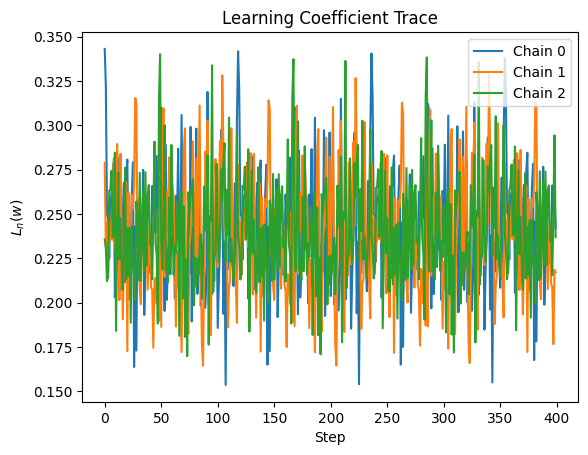

Chain 1:   6%|▌         | 23/400 [00:01<00:22, 16.47it/s]


KeyboardInterrupt: ignored

In [112]:
# Change values around until chains look healthy! Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgld_lr = 1e-7
sgld_num_chains = 3
sgld_num_draws = 400
sampling_method = SGLD

chain_health_monitoring(models_rlct, sgld_lr, sgld_num_chains, sgld_num_draws, sampling_method)

Chain 2: 100%|██████████| 200/200 [00:09<00:00, 21.41it/s] 


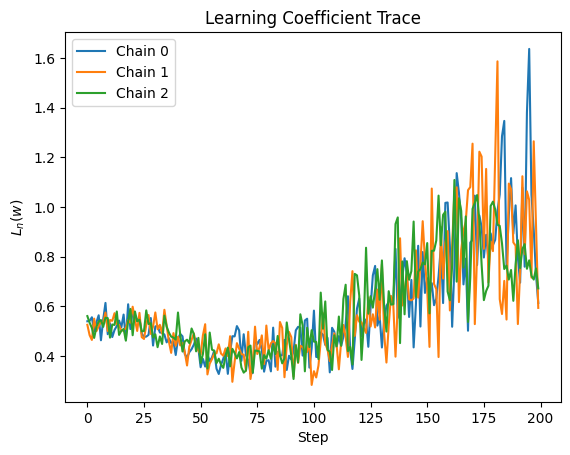

Chain 2: 100%|██████████| 200/200 [00:07<00:00, 25.17it/s] 


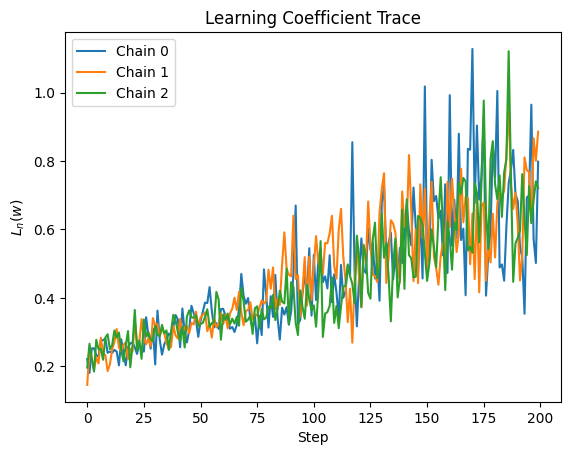

In [ ]:
# Change values around until chains look healthy!  Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgnht_lr = 1e-6
sgnht_num_chains = 3
sgnht_num_draws = 200
sampling_method = SGNHT

chain_health_monitoring(models_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sampling_method)

In [ ]:
# Only run this once the chains above look okay! It uses the same hyperparams as above but with more chains.
sgnht_num_chains = 10
sgld_num_chains  = 10

rlct_estimates_sgld_mlp1, rlct_estimates_sgnht_mlp1 = RLCT_estimate(models_rlct, train_loader_rlct, train_data_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws)

save_arrays_to_drive(
    ('rlct_estimates_sgld_mlp1', rlct_estimates_sgld_mlp1),
    ('rlct_estimates_sgnht_mlp1', rlct_estimates_sgnht_mlp1),
)

Chain 9: 100%|██████████| 100/100 [00:08<00:00, 11.23it/s]


-1573.8134591977393 -2748.7219794394023


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.09it/s]


131.20122269017858 470.42763032566893


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 17.66it/s]


-179.8311967673674 635.2333787212938


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 12.84it/s]


-106.54241104155415 824.6221670891205


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


40.30159359863382 1118.6390485679074


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.24it/s]


43.49104208183201 878.3458135909782


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 17.58it/s]


-171.80025143977997 1090.2308649948754


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


138.661376348977 1000.3116281577122


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


-296.34662752591623 1234.5660829257272


Chain 9: 100%|██████████| 100/100 [00:08<00:00, 11.50it/s]


321.8276848845639 1278.431059306235


Chain 9: 100%|██████████| 100/100 [00:07<00:00, 13.12it/s]


104.89342355317235 1253.8424620450216


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 17.91it/s]


17.733505734784156 1073.878610336387


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


164.7446327626613 1325.0284749178616


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 17.54it/s]


452.31190206039287 1613.8997692823734


Chain 9: 100%|██████████| 100/100 [00:05<00:00, 16.93it/s]

-31.08560876344581 1375.0847400679263


#### MLP2

In [ ]:
models_rlct = models_mlp2
criterion = nn.CrossEntropyLoss()
train_loader_rlct = train_loader_noisy_01
train_data_rlct = train_data_noisy_01

Chain 2: 100%|██████████| 100/100 [00:07<00:00, 14.12it/s]


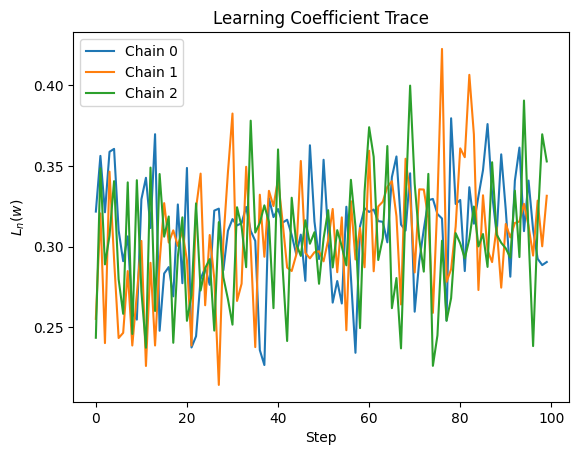

Chain 2: 100%|██████████| 100/100 [00:05<00:00, 17.56it/s]


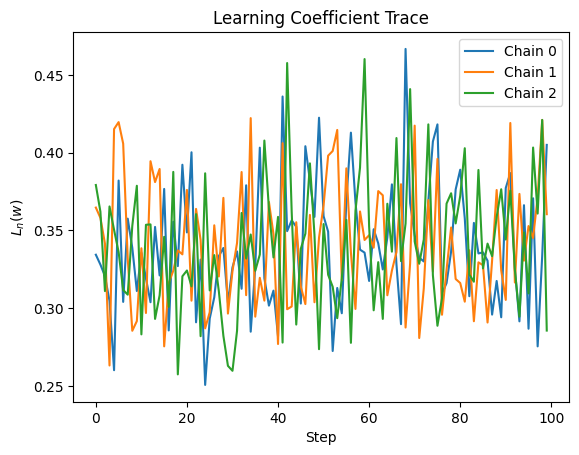

In [ ]:
# Change values around until chains look healthy! Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgld_lr = 1e-5
sgld_num_chains = 3
sgld_num_draws = 100
sampling_method = SGLD

chain_health_monitoring(models_rlct, sgld_lr, sgld_num_chains, sgld_num_draws, sampling_method)

Chain 2: 100%|██████████| 200/200 [00:08<00:00, 23.30it/s] 


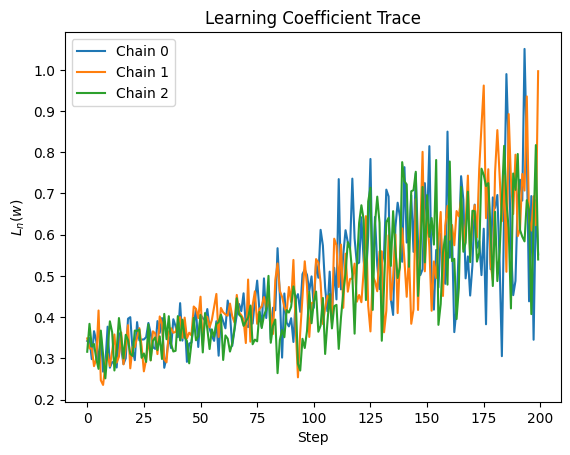

Chain 2: 100%|██████████| 200/200 [00:08<00:00, 22.33it/s] 


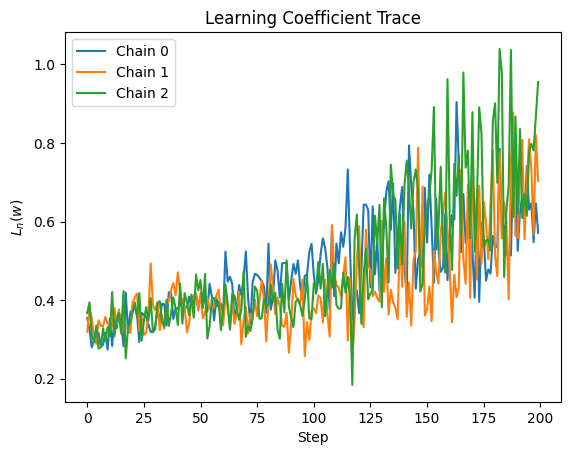

In [ ]:
# Change values around until chains look healthy!  Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgnht_lr = 1e-6
sgnht_num_chains = 3
sgnht_num_draws = 200
sampling_method = SGNHT

chain_health_monitoring(models_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sampling_method)

In [ ]:
# Only run this once the chains above look okay! It uses the same hyperparams as above but with more chains.
sgnht_num_chains = 3
sgld_num_chains  = 3

rlct_estimates_sgld_mlp2, rlct_estimates_sgnht_mlp2 = RLCT_estimate(models_rlct, train_loader_rlct, train_data_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws)

save_arrays_to_drive(
    ('rlct_estimates_sgld_mlp2', rlct_estimates_sgld_mlp2),
    ('rlct_estimates_sgnht_mlp2', rlct_estimates_sgnht_mlp2),
)

Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


-1978.601256760147 -3292.1354505088166


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]


-238.863166747241 872.5314598849678


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


212.47457065016025 2018.1348810873233


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.59it/s]


480.67743387772157 2131.5896044347537


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


97.5324803076767 2069.358699698461


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


66.68515864235252 2061.956274960077


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


-73.42455815349506 1964.344585175742


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.83it/s]


551.4442525155123 2420.770033964404


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


505.0627350682763 2377.309765819461


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


400.78424473068316 2693.866009743822


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


53.80419983381401 2132.0386494663267


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


4.041656659404772 2575.743717165926


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


637.2374214962545 2231.231609255416


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


281.0047737321455 2301.308672917908


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]

439.60421961970235 2231.9582497552806


#### MLP3

In [ ]:
models_rlct = models_mlp3
criterion = nn.CrossEntropyLoss()
train_loader_rlct = train_loader_noisy_02
train_data_rlct = train_data_noisy_02

Chain 2: 100%|██████████| 100/100 [00:07<00:00, 14.12it/s]


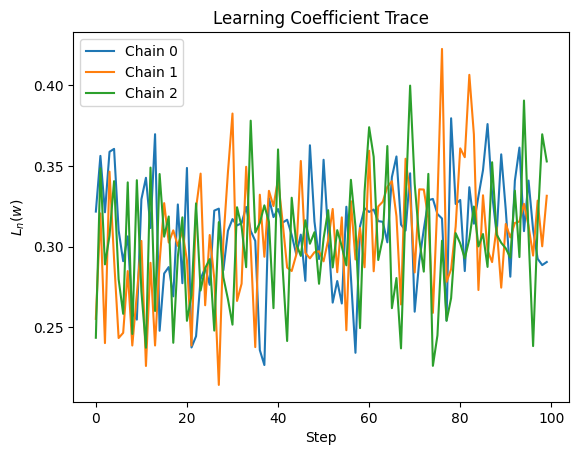

Chain 2: 100%|██████████| 100/100 [00:05<00:00, 17.56it/s]


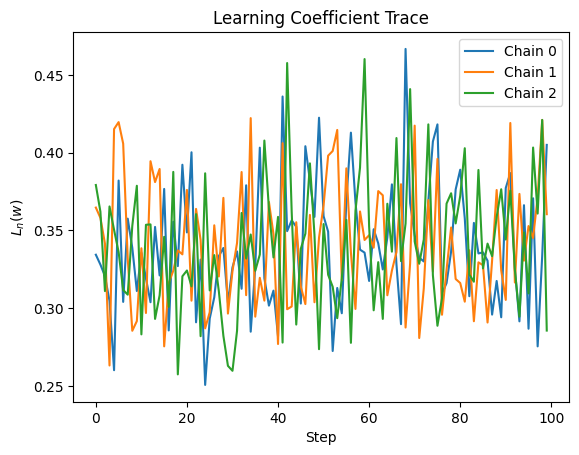

In [ ]:
# Change values around until chains look healthy! Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgld_lr = 1e-5
sgld_num_chains = 3
sgld_num_draws = 100
sampling_method = SGLD

chain_health_monitoring(models_rlct, sgld_lr, sgld_num_chains, sgld_num_draws, sampling_method)

Chain 2: 100%|██████████| 200/200 [00:08<00:00, 23.30it/s] 


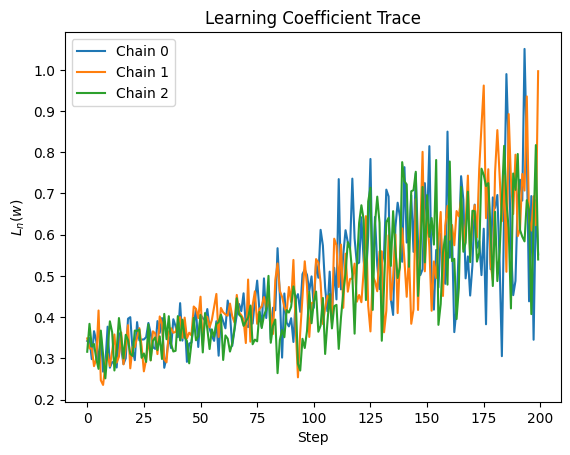

Chain 2: 100%|██████████| 200/200 [00:08<00:00, 22.33it/s] 


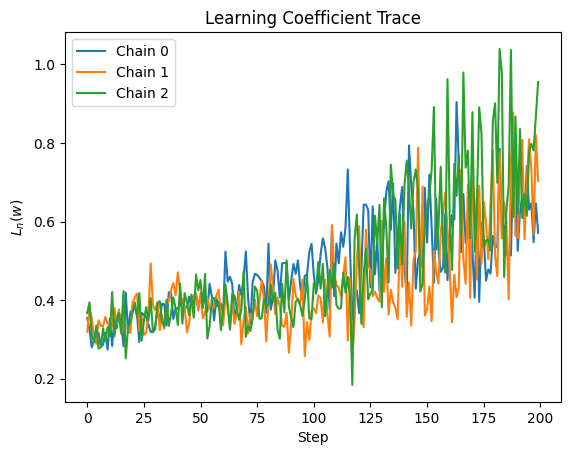

In [ ]:
# Change values around until chains look healthy!  Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgnht_lr = 1e-6
sgnht_num_chains = 3
sgnht_num_draws = 200
sampling_method = SGNHT

chain_health_monitoring(models_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sampling_method)

In [ ]:
# Only run this once the chains above look okay! It uses the same hyperparams as above but with more chains.
sgnht_num_chains = 3
sgld_num_chains  = 3

rlct_estimates_sgld_mlp3, rlct_estimates_sgnht_mlp3 = RLCT_estimate(models_rlct, train_loader_rlct, train_data_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws)

save_arrays_to_drive(
    ('rlct_estimates_sgld_mlp3', rlct_estimates_sgld_mlp3),
    ('rlct_estimates_sgnht_mlp3', rlct_estimates_sgnht_mlp3),
)

Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


-1978.601256760147 -3292.1354505088166


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]


-238.863166747241 872.5314598849678


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


212.47457065016025 2018.1348810873233


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.59it/s]


480.67743387772157 2131.5896044347537


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


97.5324803076767 2069.358699698461


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


66.68515864235252 2061.956274960077


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


-73.42455815349506 1964.344585175742


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.83it/s]


551.4442525155123 2420.770033964404


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


505.0627350682763 2377.309765819461


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


400.78424473068316 2693.866009743822


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


53.80419983381401 2132.0386494663267


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


4.041656659404772 2575.743717165926


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


637.2374214962545 2231.231609255416


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


281.0047737321455 2301.308672917908


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]

439.60421961970235 2231.9582497552806


#### MLP4

In [ ]:
models_rlct = models_mlp2
criterion = nn.CrossEntropyLoss()
train_loader_rlct = train_loader_noisy_03
train_data_rlct = train_data_noisy_03

Chain 2: 100%|██████████| 100/100 [00:07<00:00, 14.12it/s]


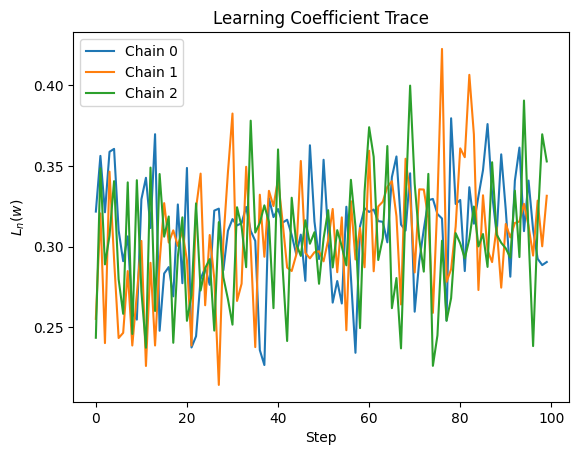

Chain 2: 100%|██████████| 100/100 [00:05<00:00, 17.56it/s]


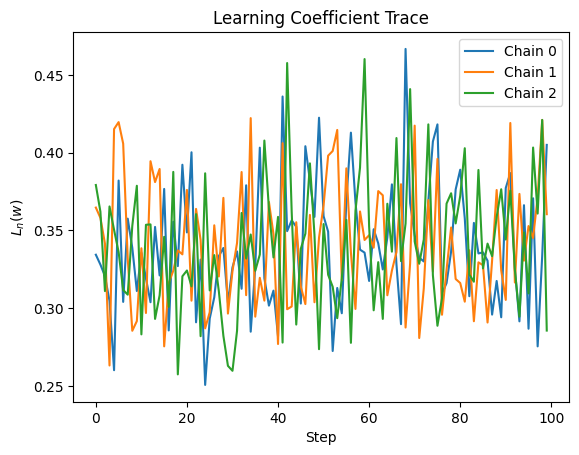

In [ ]:
# Change values around until chains look healthy! Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgld_lr = 1e-5
sgld_num_chains = 3
sgld_num_draws = 100
sampling_method = SGLD

chain_health_monitoring(models_rlct, sgld_lr, sgld_num_chains, sgld_num_draws, sampling_method)

Chain 2: 100%|██████████| 200/200 [00:08<00:00, 23.30it/s] 


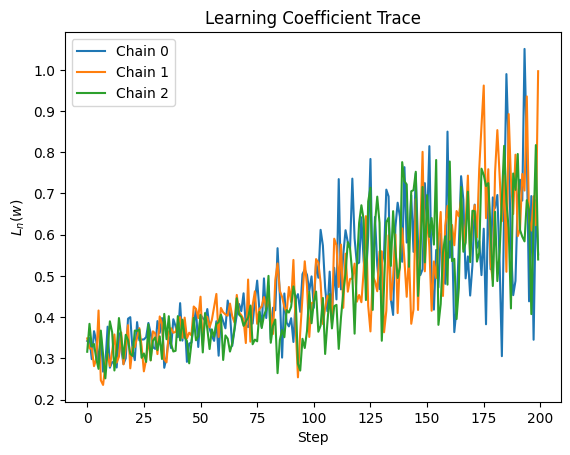

Chain 2: 100%|██████████| 200/200 [00:08<00:00, 22.33it/s] 


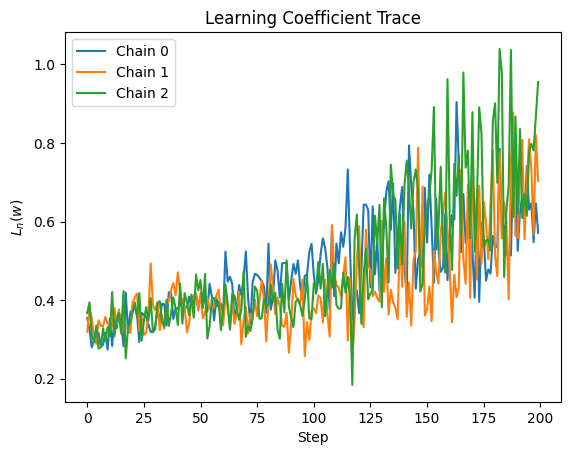

In [ ]:
# Change values around until chains look healthy!  Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgnht_lr = 1e-6
sgnht_num_chains = 3
sgnht_num_draws = 200
sampling_method = SGNHT

chain_health_monitoring(models_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sampling_method)

In [ ]:
# Only run this once the chains above look okay! It uses the same hyperparams as above but with more chains.
sgnht_num_chains = 3
sgld_num_chains  = 3

rlct_estimates_sgld_mlp4, rlct_estimates_sgnht_mlp4 = RLCT_estimate(models_rlct, train_loader_rlct, train_data_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws)

save_arrays_to_drive(
    ('rlct_estimates_sgld_mlp4', rlct_estimates_sgld_mlp4),
    ('rlct_estimates_sgnht_mlp4', rlct_estimates_sgnht_mlp4),
)

Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


-1978.601256760147 -3292.1354505088166


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]


-238.863166747241 872.5314598849678


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


212.47457065016025 2018.1348810873233


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.59it/s]


480.67743387772157 2131.5896044347537


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


97.5324803076767 2069.358699698461


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.65it/s]


66.68515864235252 2061.956274960077


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


-73.42455815349506 1964.344585175742


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.83it/s]


551.4442525155123 2420.770033964404


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


505.0627350682763 2377.309765819461


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


400.78424473068316 2693.866009743822


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


53.80419983381401 2132.0386494663267


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


4.041656659404772 2575.743717165926


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


637.2374214962545 2231.231609255416


Chain 2: 100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


281.0047737321455 2301.308672917908


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.77it/s]

439.60421961970235 2231.9582497552806


### CNNs (Incomplete)

#### CNN1

In [ ]:
models_rlct = models_cnn1
criterion = nn.CrossEntropyLoss()
train_loader_rlct = train_loader
train_data_rlct = train_data

Chain 2: 100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


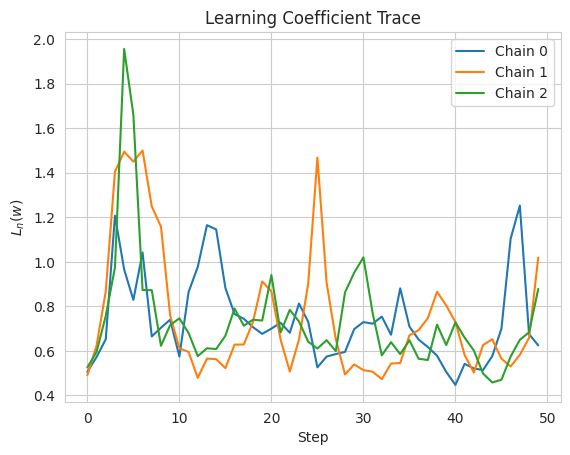

Chain 2: 100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


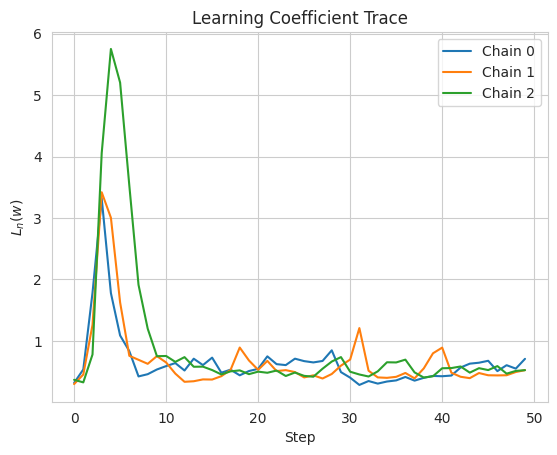

In [ ]:
# Change values around until chains look healthy! Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgld_lr = 1e-7
sgld_num_chains = 3
sgld_num_draws = 50
sampling_method = SGLD

chain_health_monitoring(models_rlct, sgld_lr, sgld_num_chains, sgld_num_draws, sampling_method)

Chain 2: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


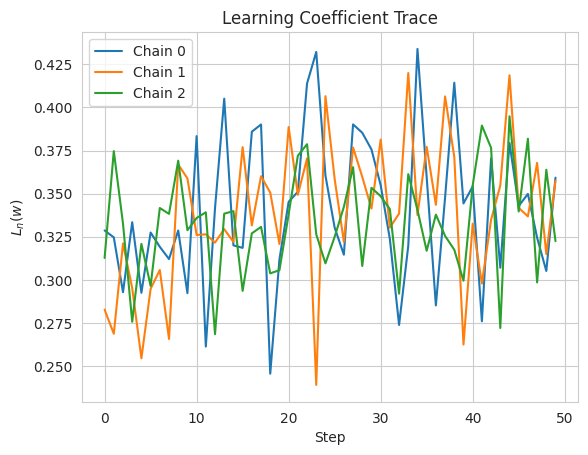

Chain 2: 100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


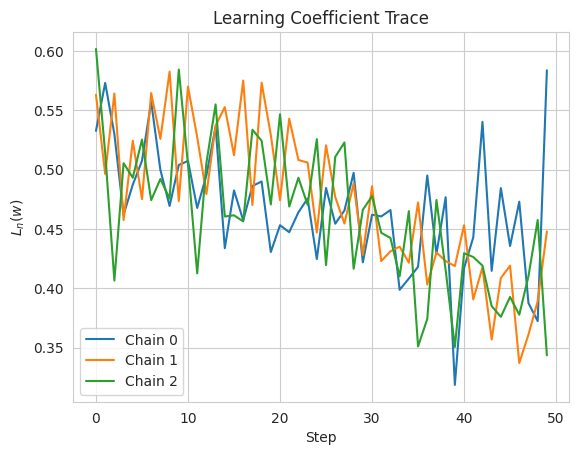

In [ ]:
# Change values around until chains look healthy!  Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgnht_lr = 5e-7
sgnht_num_chains = 3
sgnht_num_draws = 50
sampling_method = SGNHT

chain_health_monitoring(models_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sampling_method)

In [ ]:
# Only run this once the chains above look okay! It uses the same hyperparams as above but with more chains.
sgnht_num_chains = 10
sgld_num_chains  = 10

rlct_estimates_sgld_cnn1, rlct_estimates_sgnht_cnn1 = RLCT_estimate(models_rlct, train_loader_rlct, train_data_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws)

Chain 9: 100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


929.3819708589175 -188.03796626465657


Chain 9: 100%|██████████| 50/50 [00:48<00:00,  1.03it/s]

2398.6101932282063 33.81449754950835


#### CNN2

In [ ]:
models_rlct = models_cnn2
criterion = nn.CrossEntropyLoss()
train_loader_rlct = noisy_train_loader
train_data_rlct = noisy_train_data

Chain 2: 100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


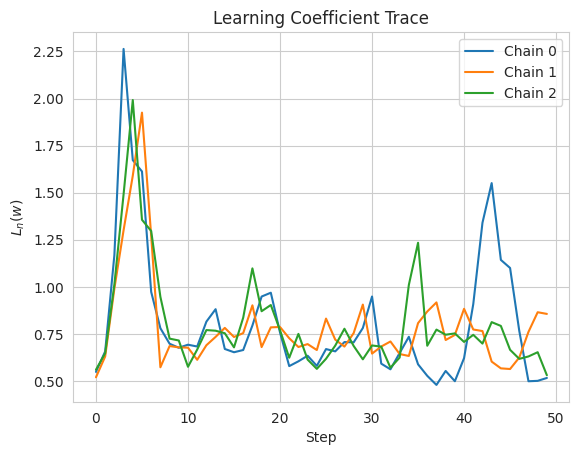

Chain 2: 100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


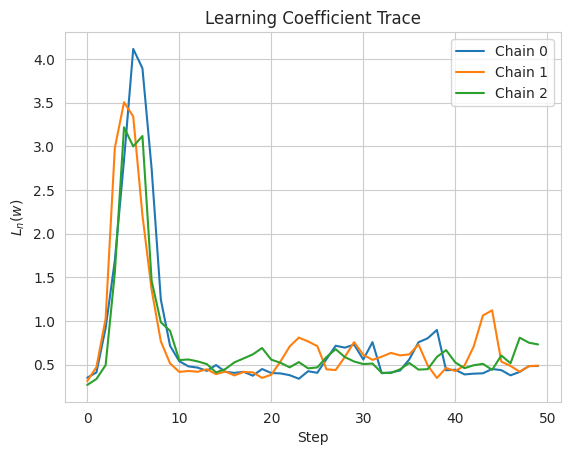

In [ ]:
# Change values around until chains look healthy! Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgld_lr = 1e-5
sgld_num_chains = 3
sgld_num_draws = 50
sampling_method = SGLD

chain_health_monitoring(models_rlct, sgld_lr, sgld_num_chains, sgld_num_draws, sampling_method)

Chain 2: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


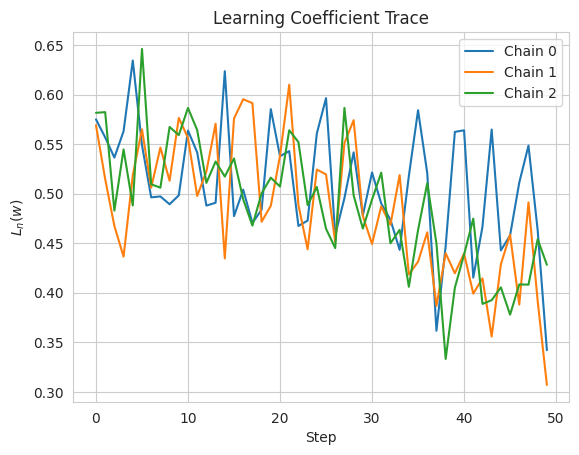

Chain 2: 100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


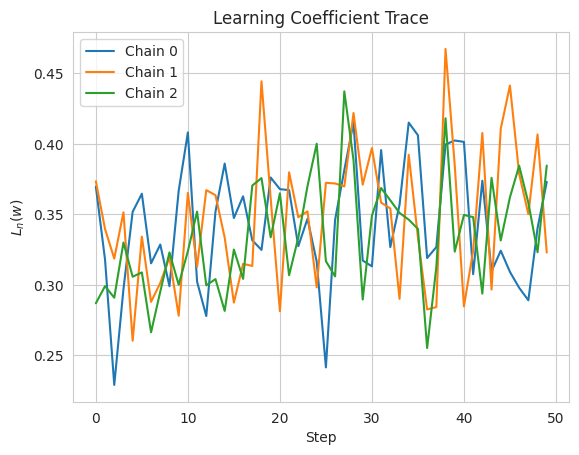

In [ ]:
# Change values around until chains look healthy!  Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgnht_lr = 5e-7
sgnht_num_chains = 3
sgnht_num_draws = 50
sampling_method = SGNHT

chain_health_monitoring(models_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sampling_method)

In [ ]:
# Only run this once the chains above look okay! It uses the same hyperparams as above but with more chains.
sgnht_num_chains = 10
sgld_num_chains  = 10

rlct_estimates_sgld_cnn2, rlct_estimates_sgnht_cnn2 = RLCT_estimate(models_rlct, train_loader_rlct, train_data_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws)

### AEs (Incomplete)

#### AE1

In [ ]:
models_rlct = models_ae1
criterion = nn.MSELoss()
train_loader_rlct = train_loader
train_data_rlct = train_data

In [ ]:
# Change values around until chains look healthy! Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgld_lr = 1e-5
sgld_num_chains = 3
sgld_num_draws = 50
sampling_method = SGLD

chain_health_monitoring(models_rlct, sgld_lr, sgld_num_chains, sgld_num_draws, sampling_method)

In [ ]:
# Change values around until chains look healthy!  Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgnht_lr = 5e-7
sgnht_num_chains = 3
sgnht_num_draws = 50
sampling_method = SGNHT

chain_health_monitoring(models_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sampling_method)

In [ ]:
# Only run this once the chains above look okay! It uses the same hyperparams as above but with more chains.
sgnht_num_chains = 10
sgld_num_chains  = 10

rlct_estimates_sgld_ae1, rlct_estimates_sgnht_ae1 = RLCT_estimate(models_rlct, train_loader_rlct, train_data_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws)

#### AE2

In [ ]:
models_rlct = models_ae2
criterion = nn.MSELoss()
train_loader_rlct = noisy_train_loader
train_data_rlct = noisy_train_data

In [ ]:
# Change values around until chains look healthy! Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgld_lr = 1e-5
sgld_num_chains = 3
sgld_num_draws = 50
sampling_method = SGLD

chain_health_monitoring(models_rlct, sgld_lr, sgld_num_chains, sgld_num_draws, sampling_method)

In [ ]:
# Change values around until chains look healthy!  Run roughly 3 chains here over 2 random models and then 10 chains in the real case.
sgnht_lr = 5e-7
sgnht_num_chains = 3
sgnht_num_draws = 50
sampling_method = SGNHT

chain_health_monitoring(models_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sampling_method)

In [ ]:
# Only run this once the chains above look okay! It uses the same hyperparams as above but with more chains.
sgnht_num_chains = 10
sgld_num_chains  = 10

rlct_estimates_sgld_ae2, rlct_estimates_sgnht_ae2 = RLCT_estimate(models_rlct, train_loader_rlct, train_data_rlct, sgnht_lr, sgnht_num_chains, sgnht_num_draws, sgld_lr, sgld_num_chains, sgld_num_draws)

## Visualising Results

### Plotting Function

In [65]:
PRIMARY, SECONDARY, TERTIARY = sns.color_palette("muted")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("pastel")[:3]

def plot_graph(train_losses, test_losses, rlct_estimates_sgnht, rlct_estimates_sgld, title):

    epochs = range(1, len(train_losses) + 1) # So we start at epoch 1 instead of epoch zero

    sns.set_style("whitegrid")

    fig, ax1 = plt.subplots()

    # Set labels and title
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color=PRIMARY)
    fig.suptitle(title)

    # Plot train and test losses
    ax1.plot(epochs, train_losses, label="Train Loss", color=PRIMARY, marker='o', markersize=8)
    ax1.plot(epochs, test_losses, label="Test Loss", color=PRIMARY_LIGHT, marker='o', markersize=8)
    ax1.tick_params(axis="y", labelcolor=PRIMARY)
    ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax1.legend(loc="lower left")

    # Create a second y-axis for the RLCT estimates
    ax2 = ax1.twinx()
    ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
    ax2.plot(epochs, rlct_estimates_sgnht, label="SGNHT", color=SECONDARY, marker='o', markersize=8)
    ax2.plot(epochs, rlct_estimates_sgld, label="SGLD", color=SECONDARY_LIGHT, marker='o', markersize=8)
    ax2.tick_params(axis="y", labelcolor=SECONDARY)
    ax2.legend(loc="center right")

    # Adjust layout and display the plot
    fig.tight_layout()
    plt.show()


### MLPs

In [103]:
plot_graph(train_losses_mlp1, test_losses_mlp1, rlct_estimates_sgnht_mlp1, rlct_estimates_sgld_mlp1, "MLP1 Normal MNIST")
plot_graph(train_losses_mlp2, test_losses_mlp2, rlct_estimates_sgnht_mlp2, rlct_estimates_sgld_mlp2, "MLP2 0.1 Noise MNIST")
plot_graph(train_losses_mlp3, test_losses_mlp3, rlct_estimates_sgnht_mlp3, rlct_estimates_sgld_mlp3, "MLP3 0.2 Noise MNIST")
plot_graph(train_losses_mlp4, test_losses_mlp4, rlct_estimates_sgnht_mlp4, rlct_estimates_sgld_mlp4, "MLP4 0.3 Noise MNIST")

NameError: ignored

### CNNs

In [ ]:
plot_graph(train_losses_cnn1, test_losses_cnn1, rlct_estimates_sgnht_cnn1, rlct_estimates_sgld_cnn1, "CNN 1 Normal MNIST")
plot_graph(train_losses_cnn2, test_losses_cnn2, rlct_estimates_sgnht_cnn2, rlct_estimates_sgld_cnn2, "CNN 2 Noisy  MNIST")

### AEs

In [ ]:
plot_graph(train_losses_ae1, test_losses_ae1, rlct_estimates_sgnht_ae1, rlct_estimates_sgld_ae1, "AE 1 Normal MNIST")
plot_graph(train_losses_ae2, test_losses_ae2, rlct_estimates_sgnht_ae2, rlct_estimates_sgld_ae2, "AE 2 Noisy  MNIST")